In [ ]:
!pip install numpy
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib

# **TODO!**

1.   Async data formatting functions for color and content frames to prevent ram crashing
2.   Make data loading function sort frames in correct sequential order by file name



In [ ]:
# Load API's needed for program

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob, os
import random
import shutil

# Variables used throughout program
average_frame_size = (144, 256, 3)
categories_to_make = ["frog", "dog", "log"]
colors = {}

# Designate which color circle will be displayed in each categories test images
for category_type in categories_to_make:
  color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
  colors[category_type] = color

In [ ]:
# Plot function to display images for testing
def plotImage(image):
  plt.figure(figsize = (15,2))
  plt.imshow(image)

In [ ]:
# Function to generate unique image data for each category
def get_image_from_category(category_type):
  pre_image = np.random.randint(0, 255, average_frame_size)
  location = (random.randint(1, 256), random.randint(1, 144))
  radius = random.randint(10, 60)
  return cv2.circle(pre_image, location, radius, colors[category_type], -1)

# Generate data for training

Code is split in order to allow recreating subdirectories when necessary

In [ ]:
# Generate data folder
path = "."
shutil.rmtree("./data")
os.mkdir(path + "/data")

In [ ]:
# Generate catergory folders
path2 = "./data"
for folders in next(os.walk(path2))[1]:
  shutil.rmtree(path2 + "/" + folders)
for category_type in categories_to_make:
  os.mkdir(path2 + "/" + category_type)

In [ ]:
# Generate video folders and video frames
path3 = "./data"

categories = next(os.walk(path3))[1]
for category in categories:
    for folder in next(os.walk(path3 + "/" + category))[1]:
      shutil.rmtree(path3 + "/" + category + "/" + folder)
    for amount in range(random.randint(50, 100)):
      os.mkdir(path3 + "/" + category + "/video" + str(random.randint(1, 2000000)))
    video_titles = next(os.walk(path3 + "/" + category))[1]
    for video in video_titles:
      path_to_folder = path3 + "/" + category + "/" + video
      print(path_to_folder)
      for index in range(random.randint(7, 10)):
        test_image = get_image_from_category(category)
        cv2.imwrite((path_to_folder + "/" + str(index) + ".png"), test_image)

# Load training data from directory

In [ ]:
# Load actual data from file path

# Folder structure should be:
# Level 1 : names of categories as folder name -> timelapse animation frogs ... etc
# Level 2 : name of video as folder name -> frog_in_sun dogs_jumping ... etc
# Level 3 : frames as png with sequential numbering as name -> 1 2 3 4 ... 10

def loadData(file_path_to_folders):
  '''Video data returns a tuple, the first element is the loaded frames
    The second element is a list of the categories as strings

    The loaded frames data is formatted as a dictionary, values are as follows:
    {category_type : [[video1_frames], [video2_frames], ...], category2_type : [...], ...}
    video_data[0]["timelapse"][2][3] gives the third timelapse video's 4th frame
  '''

  categories = next(os.walk(file_path_to_folders))[1]
  video_categories = {}

  for category in categories:
    video_categories[category] = []
    video_titles = next(os.walk(file_path_to_folders + "/" + category))[1]

    for video_title in video_titles:
      final_path = file_path_to_folders + "/" + category + "/" + video_title + "/"
      video_frames = []

      for image in glob.glob(final_path + "*.png"):
        frame = cv2.imread(image)
        if frame.shape != average_frame_size:
          frame = cv2.resize(frame, (144, 256))
        video_frames.append(frame)

      video_categories[category].append(video_frames)

  return (video_categories, categories)

Videos within each category : 

frog : 93
dog : 68
log : 87

First frame in first video within frog category : 


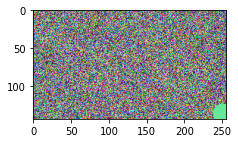

In [ ]:
'''Test loading of data using load function'''

# Video data returns a tuple, the first element is the loaded frames
# The second element is a list of the categories as strings

# The loaded frames data is formatted as a dictionary, values are as follows:
# {category_type : [[video1_frames], [video2_frames], ...], category2_type : [...], ...}
# video_data[0]["timelapse"][2][3] gives the third timelapse video's 4th frame
video_data = loadData('./data')
print("Videos within each category : \n")
for key in video_data[0].keys():
  print(key + " : " + str(len(video_data[0][key])))

print("\nFirst frame in first video within", video_data[1][0], "category : ")
image = video_data[0][(video_data[1][0])][1][5]
plotImage(image)

# Functions used for average color network data formatting

In [ ]:
# Average all frames selected in video into a single image
def averageFrames(frames):
  frameAmount = len(frames)
  averageFrame = np.zeros(average_frame_size)
  for frame in frames:
    averageFrame = averageFrame + frame
  averageFrame = averageFrame / frameAmount
  return averageFrame

# Normalize image for input
def normalizeFrame(frame):
  return (frame / 255)

# Functions used for content network data formatting

In [ ]:
def differentiateFrames(frames):
  frameAmount = len(frames)
  newFrames = []
  if frameAmount == 1:
    return frames
  for index, frame in enumerate(frames):
    if(index + 1 >= frameAmount):
      return newFrames
    frameCurrent = frame
    frameNext = frames[index + 1]
    frameDifference = frameCurrent - frameNext
    newFrames.append(normalizeFrame(frameDifference))

Format data loaded for the two networks :

In [ ]:
data_from_videos = loadData('./data')
categories = data_from_videos[1]
frame_data = data_from_videos[0]

totalFrames = 0
totalVideos = 0

for category in categories:
  for video in frame_data[category]:
    totalVideos = totalVideos + 1
    totalFrames = totalFrames + len(video)

print("Total Videos : " , str(totalVideos) , " , Total Frames : " , str(totalFrames))

# Average frame data
# {category1 : [list_of_images_from_each_video], category2 : ..., ...}
average_frames = {}
for category in categories:
  average_frames[category] = []
  for video in frame_data[category]:
    average_frames[category].append(normalizeFrame(averageFrames(video)))

# Difference frame data
# {category1 : [[video1_frames], [video2_frames]], category2 : ..., ...}
differentiated_frames = {}
for category in categories:
  differentiated_frames[category] = []
  for video in frame_data[category]:
    differentiated_frames[category].append(differentiateFrames(video))

Total Videos :  248  , Total Frames :  2106


# Create models for both networks

In [ ]:
color_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=average_frame_size),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

In [ ]:
content_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=average_frame_size),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(categories), activation='softmax')
])

In [ ]:
color_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
content_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Format data information into model usable variables

In [ ]:
# Create int key values for categories
categories_int = {}
int_categories = {}
for index, category in enumerate(categories):
  categories_int[category] = index
  int_categories[index] = category

print(categories_int)
print(int_categories)

{'frog': 0, 'dog': 1, 'log': 2}
{0: 'frog', 1: 'dog', 2: 'log'}


In [ ]:
# format data for color model in x and y dimensions
x_color_train = []
y_color_train = []
x_color_test = []
y_color_test = []

for category in categories_int.keys():
  for frame in average_frames[category]:
    x_color_train.append(frame)
    y_color_train.append(categories_int[category])

x_color_train = np.asarray(x_color_train)
y_color_train = np.asarray(y_color_train)
x_color_test = np.asarray(x_color_test)
y_color_test = np.asarray(y_color_test)

In [ ]:
# format data for content model in x and y dimensions
x_content_train = []
y_content_train = []
x_content_test = []
y_content_test = []

for category in categories_int.keys():
  for video in differentiated_frames[category]:
    for frame in video:
      x_content_train.append(frame)
      y_content_train.append(categories_int[category])

x_content_train = np.asarray(x_content_train)
y_content_train = np.asarray(y_content_train)
x_content_test = np.asarray(x_content_test)
y_content_test = np.asarray(y_content_test)

print(x_content_train.shape)
print(y_content_train.shape)

(1858, 144, 256, 3)
(1858,)


# Train models and get accuracy

In [52]:
color_model.fit(x_color_train, y_color_train, epochs=20)

Epoch 1/20
8/8 [==============================] - 11s 1s/step - loss: 0.3416 - accuracy: 0.9032
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 0.3707 - accuracy: 0.8911
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 0.2964 - accuracy: 0.9476
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 0.1755 - accuracy: 0.9758
Epoch 5/20
8/8 [==============================] - 11s 1s/step - loss: 0.1249 - accuracy: 0.9879
Epoch 6/20
8/8 [==============================] - 11s 1s/step - loss: 0.0896 - accuracy: 0.9839
Epoch 7/20
8/8 [==============================] - 11s 1s/step - loss: 0.1012 - accuracy: 0.9637
Epoch 8/20
8/8 [==============================] - 11s 1s/step - loss: 0.0835 - accuracy: 0.9718
Epoch 9/20
8/8 [==============================] - 11s 1s/step - loss: 0.0734 - accuracy: 0.9879
Epoch 10/20
8/8 [==============================] - 11s 1s/step - loss: 0.1036 - accuracy: 0.9597
Epoch 11/20
8/8 [======================

In [51]:
content_model.fit(x_content_train, y_content_train, epochs=20)

Epoch 1/20
59/59 [==============================] - 85s 1s/step - loss: 0.7929 - accuracy: 0.5457
Epoch 2/20
59/59 [==============================] - 83s 1s/step - loss: 0.8170 - accuracy: 0.5484
Epoch 3/20
59/59 [==============================] - 82s 1s/step - loss: 0.8142 - accuracy: 0.5393
Epoch 4/20
59/59 [==============================] - 82s 1s/step - loss: 0.7979 - accuracy: 0.5425
Epoch 5/20
59/59 [==============================] - 82s 1s/step - loss: 0.7914 - accuracy: 0.5463
Epoch 6/20
59/59 [==============================] - 80s 1s/step - loss: 0.7785 - accuracy: 0.5791
Epoch 7/20
59/59 [==============================] - 80s 1s/step - loss: 0.7941 - accuracy: 0.5463
Epoch 8/20
59/59 [==============================] - 79s 1s/step - loss: 0.7921 - accuracy: 0.5398
Epoch 9/20
59/59 [==============================] - 80s 1s/step - loss: 0.8063 - accuracy: 0.5495
Epoch 10/20
59/59 [==============================] - 81s 1s/step - loss: 0.7943 - accuracy: 0.5818
Epoch 11/20
59/59 [